In [20]:
import torch    
import json 
from ptlpinns.models import model, transfer
from ptlpinns.perturbation import LPM, standard
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import math

### Load model

In [21]:
undamped_path = "/home/dda24/PTL-PINNs/ptlpinns/models/train/undamped_k12"
undamped_name = "model_undamped_k12.pth"
undamped_model, training_log = model.load_model(undamped_path, undamped_name)

### Problem definition

In [22]:
N = 5120
t_span = (0, 15)
t_eval = np.linspace(t_span[0], t_span[1], N)

### Compute latent representations

In [23]:
H_dict = transfer.compute_H_dict(undamped_model, N=N, bias=True, t_span=t_span)

### Transfer parameters

In [24]:
w_list_transfer = [1]
zeta_list = [0.0]
forcing_list = [forcing.zeroes_2D(numpy=True)]
ic_list = [[1, 0]]
epsilon_list = [0.6]
p_list = [8]
q = 3

In [25]:
ode = equations.ode_oscillator_1D(w_0=w_list_transfer[0], zeta=zeta_list[0], forcing_1D=lambda t: np.zeros_like(t), q=q, epsilon=epsilon_list[0])
numerical_undamped_duffing = numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic_list[0])

## Standard Perturbation

In [26]:
NN_TL_solution_standard, perturbation_solution_standard, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, forcing_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="standard", power=q)
NN_TL_solution_standard = NN_TL_solution_standard.squeeze()

In [27]:
PINN_x_solution_standard = [perturbation_solution_standard[i][:, 0] for i in range(len(perturbation_solution_standard))]
PINN_x_solution_series_standard = standard.calculate_general_series(PINN_x_solution_standard, epsilon=epsilon_list[0])

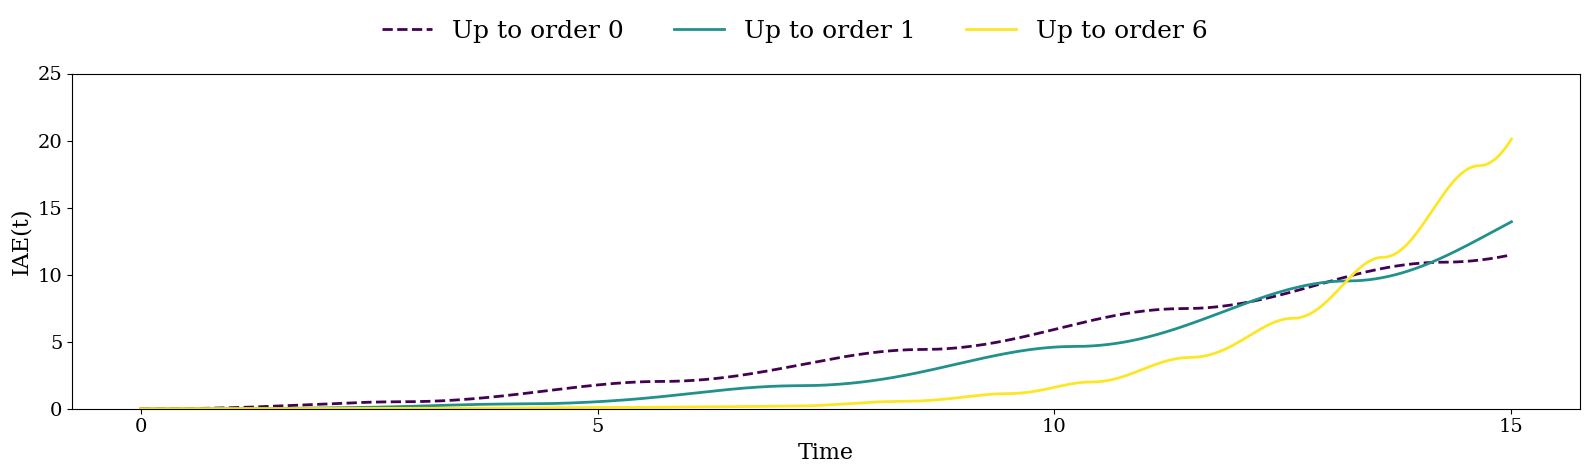

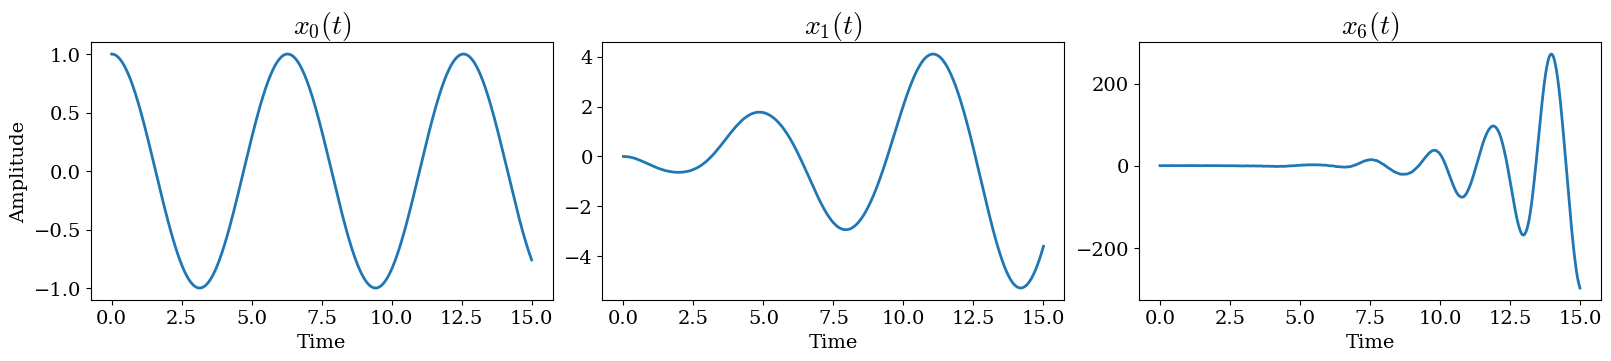

In [28]:
standard.plot_IAE_and_subplots(PINN_x_solution_series_standard, numerical_undamped_duffing, perturbation_solution_standard, t_eval, selected_orders=[0, 1, 6])

## Lindstedt-Poincare method

In [29]:
w_sol = []
NN_TL_solution_LPM, perturbation_solution_LPM, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, forcing_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="LPM", w_sol = w_sol)
NN_TL_solution_LPM = NN_TL_solution_LPM.squeeze()

In [30]:
w_final_list = []

for index in range(len(epsilon_list)):
    w_final_list.append(LPM.calculate_w_series(w_sol[0], epsilon_list[index], rwtol=1e-12))

w_final_list

[[1,
  np.float64(1.2249615417317095),
  np.float64(1.1954441094887285),
  np.float64(1.2039789574238693),
  np.float64(1.2007460172636413),
  np.float64(1.2021424509126646),
  np.float64(1.2014932278440398),
  np.float64(1.2018091972801555),
  np.float64(1.2016505719292867)]]

In [31]:
_, w_teor = LPM.estimate_period_frequency(w_0=w_list_transfer[0], zeta=zeta_list[0], ic=ic_list[0], q=q, epsilon=epsilon_list[0])
w_teor

np.float64(1.2018028846153845)

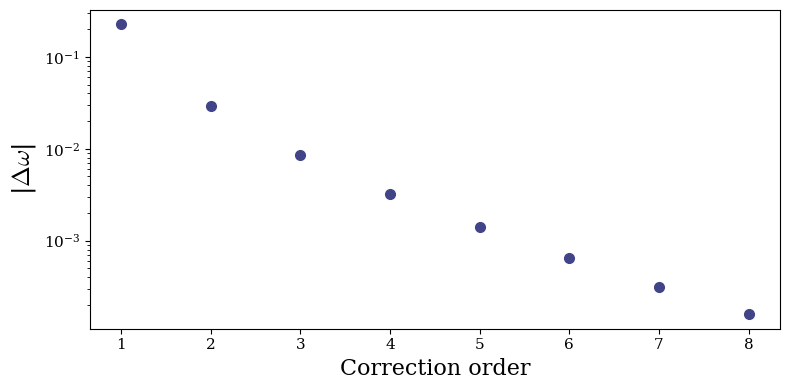

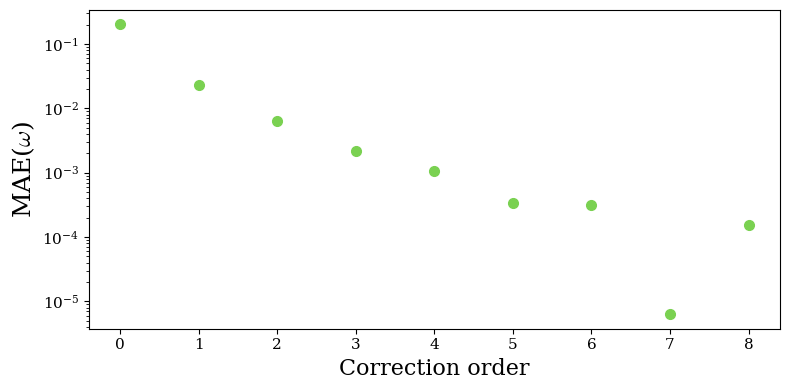

In [32]:
LPM.relative_error(w_final_list[0])
LPM.w_absolute_error(w_final_list[0], w_teor)

In [33]:
w_final = w_final_list[0][-1]
t_eval_lpm, t_eval_standard = LPM.t_eval_lpm(t_eval, w_final)
compare_len = t_eval_standard.shape[0]

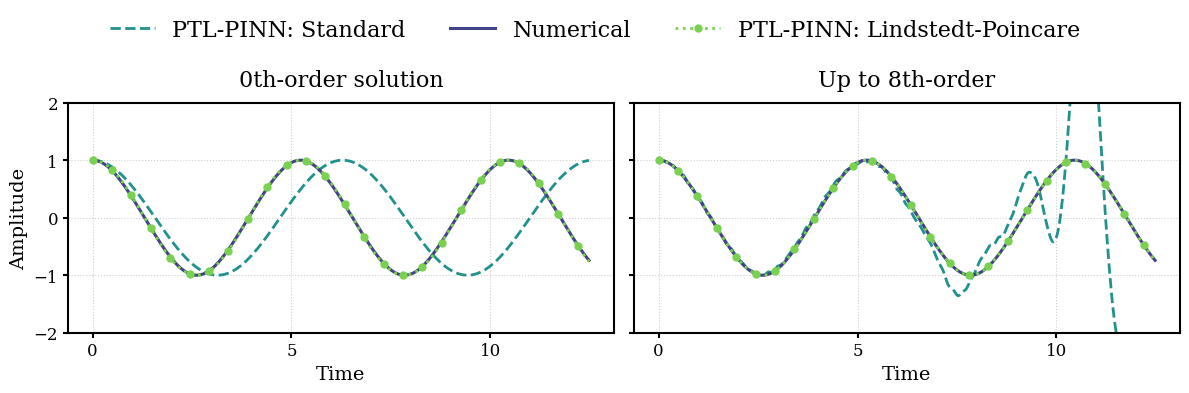

In [34]:
standard.plot_comparison_standard_vs_lpm(t_eval_standard, t_eval_lpm, [i[:compare_len] for i in perturbation_solution_standard], NN_TL_solution_standard[:compare_len], perturbation_solution_LPM, NN_TL_solution_LPM, numerical_undamped_duffing[:, :compare_len], order=p_list[0])